In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
agent_log_env = pd.read_csv("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/output_20240702_204607/agent_log.csv")

with open("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/myparams/model_params.yaml", 'r') as stream:
    input_params = yaml.safe_load(stream)

## Alcohol Analysis

In [5]:
#setting up target variables for alc- 0: non-drinker, 1: Cat I, 2: Cat II, 3: Cat III
alc_use_props = input_params['ALC_USE_PROPS']
alc_use_targets = [alc_use_props[0], alc_use_props[1], alc_use_props[2], alc_use_props[3]]

if 'instance' in agent_log_env.columns:
    all_instances_data = [instance_data for _, instance_data in agent_log_env.groupby('instance')]
else:
    # Fallback: consider entire data as a single instance
    all_instances_data = [agent_log_env]
    
all_alc_use_proportions_by_tick = []

for i, agent_dt in enumerate(all_instances_data):
    last_tick = agent_dt['tick'].max()
    selected_ticks = np.append(np.arange(1, last_tick, 10), last_tick)
    
    # Calculate alcohol use proportions for each instance
    alc_use_proportions = agent_dt[agent_dt['tick'].isin(selected_ticks)].groupby('tick').apply(
        lambda df: pd.Series({
            'Non_Drinking': (df['alc_use_status'] == 0).mean(),
            'Category_I': (df['alc_use_status'] == 1).mean(),
            'Category_II': (df['alc_use_status'] == 2).mean(),
            'Category_III': (df['alc_use_status'] == 3).mean()
        })
    ).reset_index()
    
    alc_use_proportions_long = alc_use_proportions.melt(id_vars='tick', 
                                                        var_name='alc_use_status', 
                                                        value_name='proportion')
    
    alc_use_proportions_long['instance'] = i
    
    all_alc_use_proportions_by_tick.append(alc_use_proportions_long)
    

/var/folders/5w/_sx0pyps50s6zzsjl55lmt340000gn/T/ipykernel_45762/1702593889.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  alc_use_proportions = agent_dt[agent_dt['tick'].isin(selected_ticks)].groupby('tick').apply(


In [8]:
#prepping dataframe for graph

if all_alc_use_proportions_by_tick:
    combined_alc_use_proportions = pd.concat(all_alc_use_proportions_by_tick)
else:
    raise ValueError("No data to concatenate")

# Calculate mean and range for each sampled tick across all instances
aggregated_alc_use_proportions = combined_alc_use_proportions.groupby(['tick', 'alc_use_status']).agg(
    mean_proportion=('proportion', 'mean'),
    min_proportion=('proportion', 'min'),
    max_proportion=('proportion', 'max')
).reset_index()

alc_colors = {
    'Non_Drinking': '#377eb8', 
    'Category_I': '#ff7f00', 
    'Category_II': '#4daf4a', 
    'Category_III': '#e41a1c'
}

half_time = aggregated_alc_use_proportions['tick'].max() / 365 / 2

target_alc_use_df = pd.DataFrame({
    'alc_use_status': list(alc_colors.keys()),
    'target_pct': alc_use_targets,
    'color': list(alc_colors.values())
})

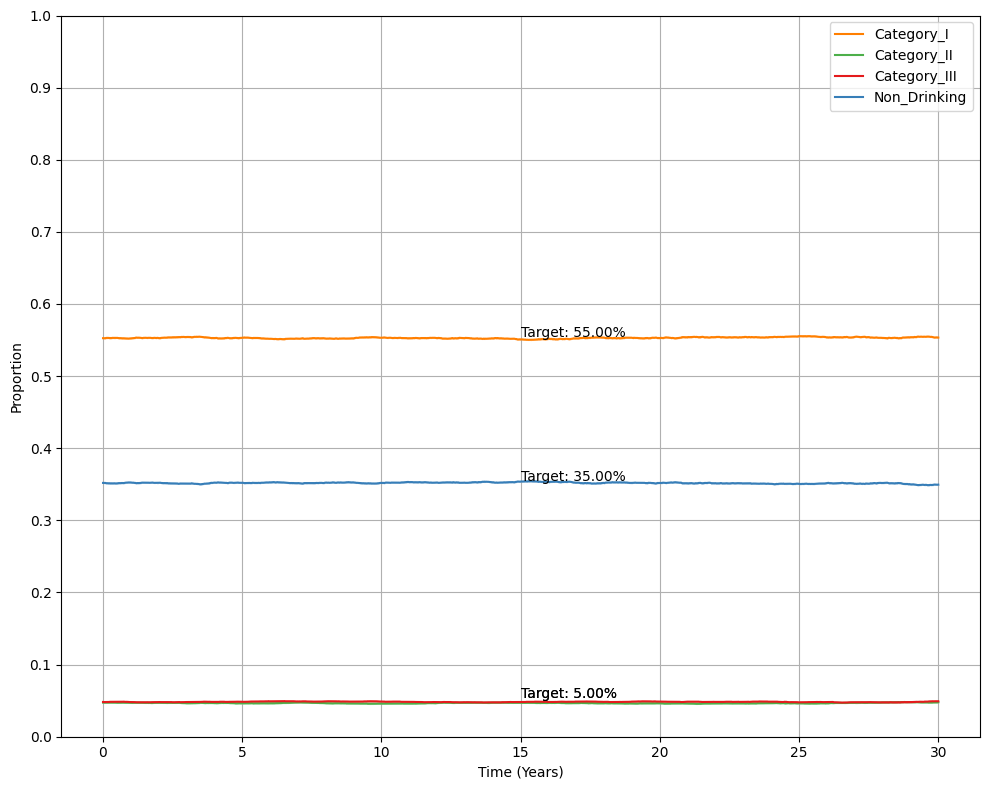

In [9]:
ig, ax = plt.subplots(figsize=(10, 8))

for alc_use_status, group_data in aggregated_alc_use_proportions.groupby('alc_use_status'):
    ax.fill_between(group_data['tick'] / 365, group_data['min_proportion'], group_data['max_proportion'], 
                    color=alc_colors[alc_use_status], alpha=0.3)
    ax.plot(group_data['tick'] / 365, group_data['mean_proportion'], color=alc_colors[alc_use_status], label=alc_use_status)

for _, row in target_alc_use_df.iterrows():
    ax.text(half_time, row['target_pct'], f"Target: {row['target_pct'] * 100:.2f}%", color='black', va='bottom')

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Time (Years)")
ax.set_ylabel("Proportion")
ax.legend(title='')
ax.grid(True)
plt.tight_layout()

plt.show()

## Smoking Analysis

In [10]:
#target proportions from yaml file
smoking_props = input_params['SMOKING_PREV']

targets_smoking = {
    "CURRENT": 0.1154314,
    "FORMER": 0.2294748,
    "NEVER": 0.6550938
}

In [11]:
# Retrieving final data at end of run
agent_dt = agent_log_env 

# Last tick
last_tick = agent_dt['tick'].max()

# Compute metrics
smoking_last_tick = (
    agent_dt[agent_dt['tick'] == last_tick]
    .groupby('smoking_status')
    .size()
    .reset_index(name='N')
)
smoking_last_tick['pct'] = (smoking_last_tick['N'] / smoking_last_tick['N'].sum() * 100).round(3)
print(smoking_last_tick)

  smoking_status     N     pct
0        Current  1440  14.397
1         Former  2080  20.796
2          Never  6482  64.807


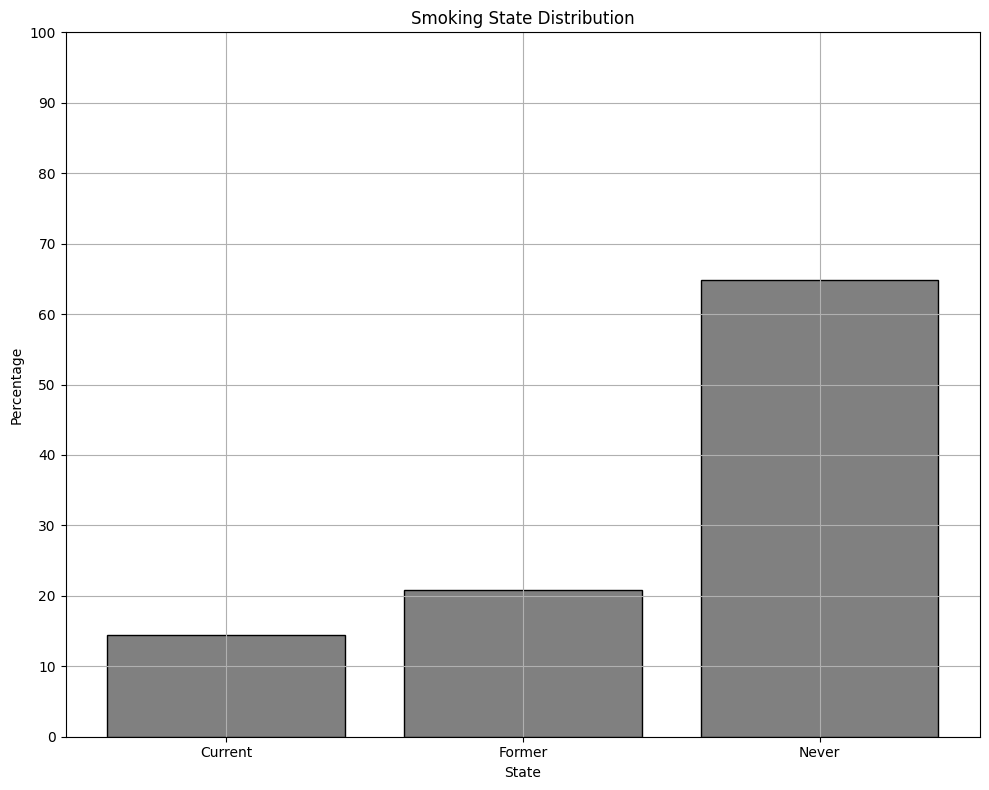

In [12]:
# Plot the smoking state distribution
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(smoking_last_tick['smoking_status'], smoking_last_tick['pct'], color='gray', edgecolor='black')
ax.set_title("Smoking State Distribution")
ax.set_xlabel("State")
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(True)
plt.tight_layout()
plt.savefig("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/output_20240702_204607/smoking_state_distribution.png")
plt.show()

In [13]:
# Compute metrics over time
time_ticks = np.append(np.arange(1, last_tick, 10), last_tick)
smoking_by_tick = agent_dt[agent_dt['tick'].isin(time_ticks)].groupby('tick').apply(
    lambda df: pd.Series({
        'Current': (df['smoking_status'] == "Current").mean(),
        'Former': (df['smoking_status'] == "Former").mean(),
        'Never': (df['smoking_status'] == "Never").mean()
    })
).reset_index()

# Convert the data from wide to long format
smoking_long = smoking_by_tick.melt(id_vars='tick', 
                                    var_name='smoking_status', 
                                    value_name='proportion')

/var/folders/5w/_sx0pyps50s6zzsjl55lmt340000gn/T/ipykernel_45762/616460626.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoking_by_tick = agent_dt[agent_dt['tick'].isin(time_ticks)].groupby('tick').apply(


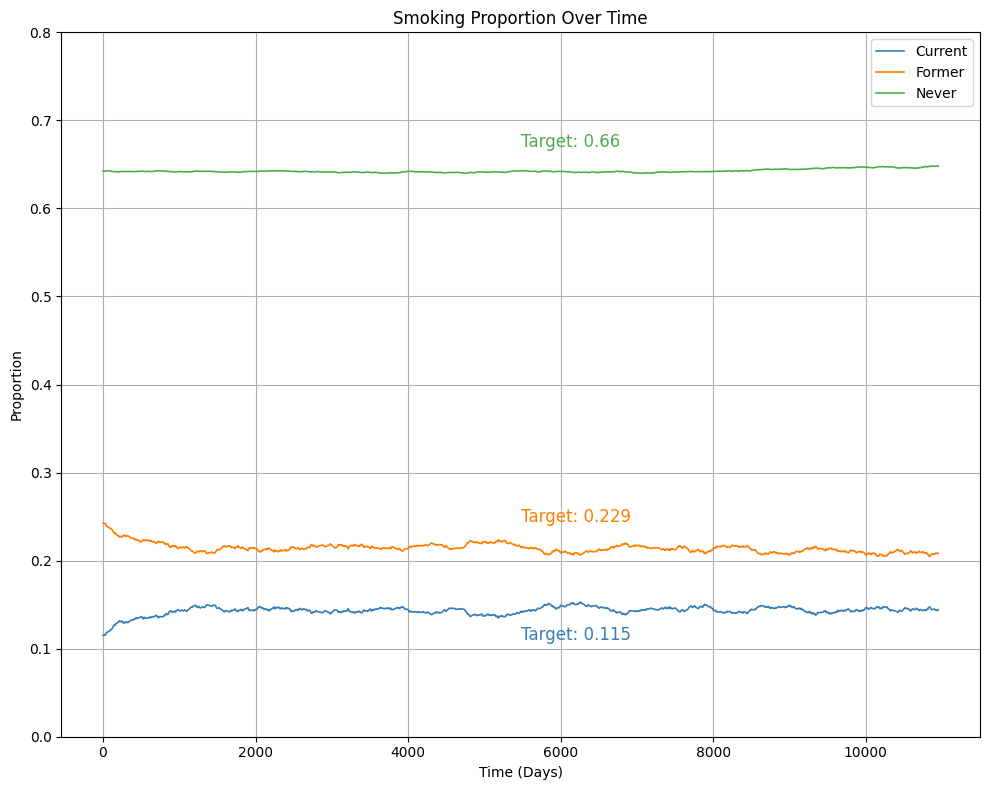

In [14]:
# Plot the time series
fig, ax = plt.subplots(figsize=(10, 8))
colors = {
    "Current": "#377eb8",
    "Former": "#ff7f00",
    "Never": "#4daf4a"
}
for status, group in smoking_long.groupby('smoking_status'):
    ax.plot(group['tick'], group['proportion'], label=status, color=colors[status], linewidth=1.2)
ax.set_title("Smoking Proportion Over Time")
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Proportion")
ax.set_ylim(0, 0.8)
ax.set_yticks(np.arange(0, 0.9, 0.1))
ax.legend(title='')
ax.grid(True)

# Add target lines
half_time = max(smoking_long['tick']) / 2
ax.text(half_time, targets_smoking["CURRENT"] - 0.01, f"Target: {targets_smoking['CURRENT']:.3f}", color="#377eb8", verticalalignment='bottom', size=12)
ax.text(half_time, targets_smoking["FORMER"] + 0.01, f"Target: {targets_smoking['FORMER']:.3f}", color="#ff7f00", verticalalignment='bottom', size=12)
ax.text(half_time, targets_smoking["NEVER"] + 0.01, f"Target: {targets_smoking['NEVER']:.2f}", color="#4daf4a", verticalalignment='bottom', size=12)

plt.tight_layout()
plt.show()